# 1. Data Preprocessing and Basic Characterization

This notebook covers:
- Data validation and preprocessing
- Fundamental graph statistics
- Initial visualizations

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import os
import random
random.seed(42)

from preprocessing import *

## Load Data

In [78]:
data_path = '~/local/data/GraphConnectomicsPOC/flywire'
data_path = os.path.expanduser(data_path)
save_data = False

In [79]:
path_connections = os.path.join(data_path, "connections.csv")
connections_df = pd.read_csv(path_connections)
connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [80]:
# Count unique entries in pre_root_id and post_root_id
unique_pre = connections_df['pre_root_id'].nunique()
unique_post = connections_df['post_root_id'].nunique()

print(f"Unique pre_root_id entries: {unique_pre}")
print(f"Unique post_root_id entries: {unique_post}")

# Count unique entries in both columns combined
unique_combined = pd.concat([connections_df['pre_root_id'], connections_df['post_root_id']]).nunique()
print(f"Unique entries in both columns combined: {unique_combined}")

Unique pre_root_id entries: 129351
Unique post_root_id entries: 125192
Unique entries in both columns combined: 134181


This means that there are 134181 unique neurons in the connectome, and the full connectivity matrix will be 134181 by 134181 in size. We will query for a subset of these neurons for our miniature analysis.

## Query and preprocess data

In [81]:
path_classification = os.path.join(data_path, "classification.csv")
classification_df = pd.read_csv(path_classification)
classification_df

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [82]:
# List of cell types of interest
ctoi = ["AOTU046", "Delta7", "EL", "ER2", "ER3a", "ER3d", "ER3m", "ER3p", "ER3w", "ER4d", "ER4m", "EPG", "TuBu01", "TuBu02", "TuBu03", "TuBu07", "TuBu08", "TuBu09"]

# List of all cell types (in hemibrain_type)
col_hemibrain_type = classification_df['hemibrain_type'].str.split(',')
all_hemibrain_type = col_hemibrain_type.explode().unique().astype(str).tolist()

# Verify if the cell types of interest are in the list
for cell_type in ctoi:
    print(f"Matching type found for {cell_type}: {cell_type in all_hemibrain_type}")

# Get the root_id of neurons of the cell types of interest
neurons_ctoi = {}
for cell_type in ctoi:
    neurons_ctoi[cell_type] = classification_df[col_hemibrain_type.apply(lambda x: cell_type in x if isinstance(x, list) else False)]["root_id"].values.tolist()

# Print the number of neurons in each cell type
for cell_type, neurons in neurons_ctoi.items():
    print(f"{cell_type}: {len(neurons)} neurons")

# Unique list of neurons in all cell types of interest
noi_set = set()
for cell_type in ctoi:
    noi_set.update(neurons_ctoi[cell_type])
noi_list = list(noi_set)

# Generate a list of cell types corresponding to each root_id in noi_list
ctoi_list = []
for root_id in noi_list:
    # hemibrain_type = classification_df[classification_df["root_id"] == root_id]["hemibrain_type"].values
    # cell_type = classification_df[classification_df["root_id"] == root_id]["cell_type"].values
    is_in_hemibrain = [classification_df[classification_df["root_id"] == root_id]["hemibrain_type"].str.contains(cell_type, na=False).any() for cell_type in ctoi]
    is_in_cell_type = [classification_df[classification_df["root_id"] == root_id]["cell_type"].str.contains(cell_type, na=False).any() for cell_type in ctoi]
    if any(is_in_hemibrain):
        ctoi_list.append(ctoi[is_in_hemibrain.index(True)])
    elif any(is_in_cell_type):
        ctoi_list.append(ctoi[is_in_cell_type.index(True)])
    else:
        ctoi_list.append(None)

print(f"Generated ctoi_list with {len(ctoi_list)} entries")

Matching type found for AOTU046: True
Matching type found for Delta7: True
Matching type found for EL: True
Matching type found for ER2: True
Matching type found for ER3a: True
Matching type found for ER3d: True
Matching type found for ER3m: True
Matching type found for ER3p: True
Matching type found for ER3w: True
Matching type found for ER4d: True
Matching type found for ER4m: True
Matching type found for EPG: True
Matching type found for TuBu01: True
Matching type found for TuBu02: True
Matching type found for TuBu03: True
Matching type found for TuBu07: True
Matching type found for TuBu08: True
Matching type found for TuBu09: True
AOTU046: 4 neurons
Delta7: 40 neurons
EL: 17 neurons
ER2: 41 neurons
ER3a: 37 neurons
ER3d: 51 neurons
ER3m: 16 neurons
ER3p: 17 neurons
ER3w: 25 neurons
ER4d: 26 neurons
ER4m: 11 neurons
EPG: 47 neurons
TuBu01: 11 neurons
TuBu02: 12 neurons
TuBu03: 44 neurons
TuBu07: 17 neurons
TuBu08: 27 neurons
TuBu09: 32 neurons
Generated ctoi_list with 475 entries


In [83]:
## Shuffle the noi_list and reorder ctoi_list accordingly
# Create a list of indices for shuffling
indices = list(range(len(noi_list)))
random.shuffle(indices)

# Reorder noi_list based on shuffled indices
noi_list_shuffled = [noi_list[i] for i in indices]

# Reorder ctoi_list based on the same shuffled indices
ctoi_list_shuffled = [ctoi_list[i] for i in indices]

# Update the original lists
noi_list = noi_list_shuffled
ctoi_list = ctoi_list_shuffled

print(f"Shuffled noi_list and ctoi_list")

Shuffled noi_list and ctoi_list


In [84]:
print(f"Aggregated number of unique neurons in all neuropils of interest: {len(noi_list)}")

Aggregated number of unique neurons in all neuropils of interest: 475


In [85]:
# Filter connections to only include neurons in the list
filtered_connections_df = connections_df[
    (connections_df["pre_root_id"].isin(noi_list)) &
    (connections_df["post_root_id"].isin(noi_list))
].copy()
del connections_df, classification_df
filtered_connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
20,720575940622252493,720575940639214655,EB,26,GABA
25,720575940625516830,720575940624373837,EB,17,GABA
27,720575940622252493,720575940630658807,EB,15,GABA
35,720575940629244166,720575940639214655,EB,47,GABA
62,720575940624469444,720575940615957393,AOTU_R,14,GLUT
...,...,...,...,...,...
3868339,720575940637899197,720575940612938902,BU_L,4,ACH
3868802,720575940616569601,720575940625508500,PB,5,ACH
3868862,720575940623317321,720575940609716430,FB,1,GABA
3869372,720575940623466632,720575940629213639,CRE_L,1,GABA


In [86]:
print(f"The neurotransmitters involved are: {filtered_connections_df['nt_type'].unique()}")

The neurotransmitters involved are: ['GABA' 'GLUT' 'ACH' 'DA' 'OCT' 'SER']


In [87]:
# Manually assign weights to neurotransmitters
# These weights are used to scale the number of synapses between neurons
nt_weights = {
    'GABA': -1, # References?
    'ACH': 1,
    'GLU': -1,
    'DA': 1,
    'SER': 1,
    'OCT': 1
}

In [88]:
## Generate a connectivity matrix
# Calculate the connectivity between each pair of neurons
filtered_connections_df.loc[:, 'connectivity'] = filtered_connections_df['syn_count'] * filtered_connections_df['nt_type'].map(nt_weights)

# Group the connections by neuron pair
grouped_connections_df = filtered_connections_df.groupby(['pre_root_id', 'post_root_id']).agg({'connectivity': 'sum'}).reset_index()

# Functional connectivity matrix
n_neurons = len(noi_list)
functional_connectivity_matrix = np.zeros((n_neurons, n_neurons))
for _, row in grouped_connections_df.iterrows():
    pre_id = row['pre_root_id']
    post_id = row['post_root_id']
    conn = row['connectivity']
    pre_idx = noi_list.index(pre_id)
    post_idx = noi_list.index(post_id)
    functional_connectivity_matrix[pre_idx, post_idx] = conn

del filtered_connections_df, grouped_connections_df

# Structural connectivity matrix
structural_connectivity_matrix = functional_connectivity_matrix.copy()
structural_connectivity_matrix = np.abs(structural_connectivity_matrix)

if save_data:
    functional_df = pd.DataFrame(functional_connectivity_matrix, index=noi_list, columns=noi_list)
    functional_df.to_csv(os.path.join(data_path, 'functional_connectivity_matrix.csv'))
    structural_df = pd.DataFrame(structural_connectivity_matrix, index=noi_list, columns=noi_list)
    structural_df.to_csv(os.path.join(data_path, 'structural_connectivity_matrix.csv'))

structural_connectivity_matrix, functional_connectivity_matrix

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 24.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 18., ...,  0.,  0.,  0.]]),
 array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0., -24.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0., -18., ...,   0.,   0.,   0.]]))

## Visualisation

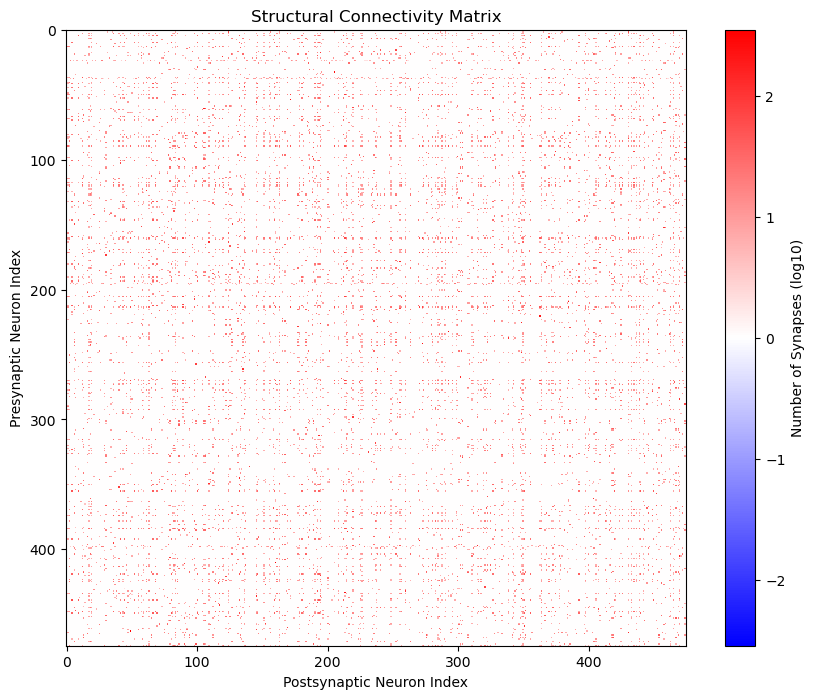

In [89]:
plt.figure(figsize=(10, 8))
# plt.imshow(structural_connectivity_matrix, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(structural_connectivity_matrix)), vmax=np.max(np.abs(structural_connectivity_matrix)))
plt.imshow(np.log10(np.abs(structural_connectivity_matrix) + 1) * np.sign(structural_connectivity_matrix), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(structural_connectivity_matrix) + 1)), 
           vmax=np.max(np.log10(np.abs(structural_connectivity_matrix) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Structural Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

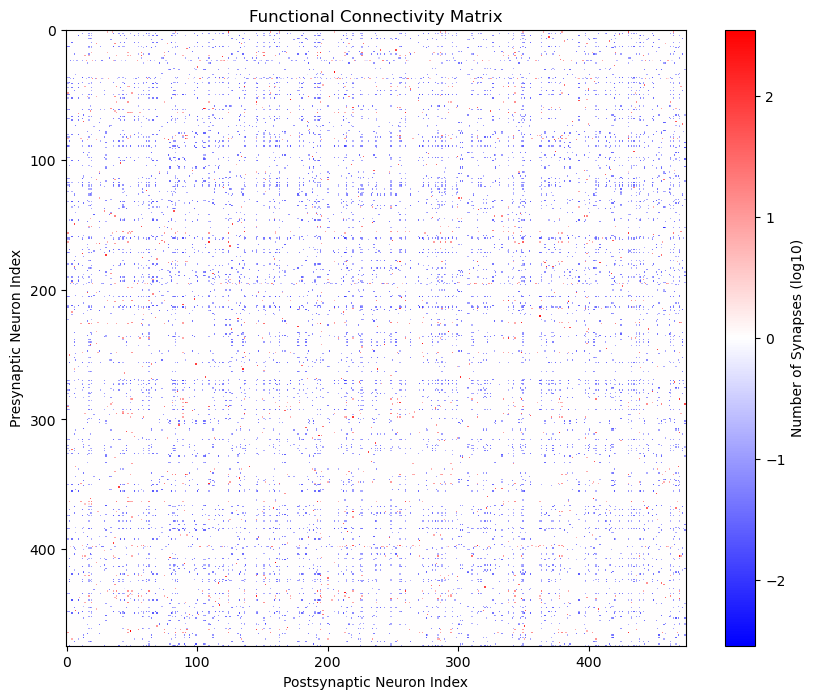

In [104]:
plt.figure(figsize=(10, 8))
# plt.imshow(functional_connectivity_matrix, cmap='bwr', aspect='auto', vmin=-np.max(np.abs(functional_connectivity_matrix)), vmax=np.max(np.abs(functional_connectivity_matrix)))
plt.imshow(np.log10(np.abs(functional_connectivity_matrix) + 1) * np.sign(functional_connectivity_matrix), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(functional_connectivity_matrix) + 1)), 
           vmax=np.max(np.log10(np.abs(functional_connectivity_matrix) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Functional Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

In [91]:
print(f"Structural connectivity matrix shape: {structural_connectivity_matrix.shape}")
print(f"Functional connectivity matrix shape: {functional_connectivity_matrix.shape}")
print(f"The shuffuled list of neuron types is: {ctoi_list}")

Structural connectivity matrix shape: (475, 475)
Functional connectivity matrix shape: (475, 475)
The shuffuled list of neuron types is: ['ER3a', 'EPG', 'ER2', 'TuBu09', 'ER4d', 'TuBu09', 'ER3w', 'ER3a', 'TuBu03', 'ER4d', 'TuBu03', 'Delta7', 'ER2', 'ER3m', 'Delta7', 'TuBu07', 'ER3d', 'EPG', 'ER3w', 'EPG', 'TuBu09', 'ER3a', 'TuBu09', 'AOTU046', 'Delta7', 'ER3d', 'ER2', 'TuBu08', 'TuBu08', 'ER2', 'ER3d', 'Delta7', 'TuBu01', 'ER3a', 'ER3a', 'Delta7', 'ER2', 'AOTU046', 'Delta7', 'TuBu07', 'ER2', 'ER4d', 'TuBu03', 'EPG', 'ER4d', 'TuBu07', 'ER3w', 'Delta7', 'Delta7', 'ER4m', 'Delta7', 'TuBu03', 'ER4d', 'TuBu01', 'TuBu08', 'EPG', 'Delta7', 'EL', 'ER3p', 'EPG', 'TuBu03', 'ER2', 'TuBu09', 'EPG', 'TuBu08', 'ER3m', 'ER4d', 'TuBu03', 'ER2', 'ER4d', 'TuBu02', 'ER3d', 'TuBu07', 'ER3a', 'ER3a', 'Delta7', 'TuBu03', 'ER3d', 'ER3d', 'ER3d', 'ER4d', 'EPG', 'ER2', 'EPG', 'TuBu03', 'ER2', 'ER3d', 'Delta7', 'ER3d', 'ER4m', 'ER3a', 'EL', 'EPG', 'TuBu09', 'ER3m', 'TuBu09', 'ER3d', 'TuBu03', 'ER2', 'ER3d', 'ER

In [92]:
# Normalise the connectivity matrix
def row_normalize(matrix):
    """Row normalize the matrix."""
    row_sums = matrix.sum(axis=1, keepdims=True)
    result = np.zeros_like(matrix)
    np.divide(matrix, row_sums, out=result, where=row_sums != 0)
    return result

def col_normalize(matrix):
    """Column normalize the matrix."""
    col_sums = matrix.sum(axis=0, keepdims=True)
    result = np.zeros_like(matrix)
    np.divide(matrix, col_sums, out=result, where=col_sums != 0)
    return result

# def symmetric_normalize(matrix):
#     """Symmetric normalize the matrix."""
#     row_normalized = row_normalize(matrix)
#     result = 
#     return result

In [93]:
# # Construct feature matrices
# # Each row vector represents a neuron, including both in- and out-degree
# structural_feature_matrix = [structural_connectivity_matrix, structural_connectivity_matrix.T]
# functional_feature_matrix = [functional_connectivity_matrix, functional_connectivity_matrix.T]

# normalized_structural_feature_matrix = row_normalize(structural_connectivity_matrix)
# normalized_functional_feature_matrix = row_normalize(functional_connectivity_matrix)

In [94]:
row_normalized_structural_connectivity_matrix = row_normalize(structural_connectivity_matrix)

## Basic Matrix Validation and Statistics

Following section 1.1 of the project plan, let's validate the connectivity matrix and compute fundamental statistics.

In [95]:
A = structural_connectivity_matrix
# A = row_normalized_structural_connectivity_matrix
# A = functional_connectivity_matrix
# A = row_normalized_structural_connectivity_matrix + functional_connectivity_matrix

In [96]:
# Import validation functions
from preprocessing.validation import validate_connectivity_matrix, compute_degree_statistics, compute_weight_statistics

# Validate the connectivity matrix
validation_results = validate_connectivity_matrix(A)
print("=== Connectivity Matrix Validation ===")
for key, value in validation_results.items():
    print(f"{key}: {value}")

print("\n=== Degree Statistics ===")
degree_stats = compute_degree_statistics(A)
print(f"In-degree - Mean: {degree_stats['in_degree_stats']['mean']:.2f}, Std: {degree_stats['in_degree_stats']['std']:.2f}")
print(f"Out-degree - Mean: {degree_stats['out_degree_stats']['mean']:.2f}, Std: {degree_stats['out_degree_stats']['std']:.2f}")
print(f"Degree correlation: {degree_stats.get('degree_correlation', 'N/A'):.3f}")

print("\n=== Weight Statistics ===")
weight_stats = compute_weight_statistics(A)
if 'no_connections' not in weight_stats:
    ws = weight_stats['weight_stats']
    print(f"Weight distribution - Mean: {ws['mean']:.2f}, Std: {ws['std']:.2f}, Median: {ws['median']:.2f}")
    print(f"Positive weights: {ws['n_positive']}, Negative weights: {ws['n_negative']}")
    print(f"Range: [{ws['min']:.2f}, {ws['max']:.2f}]")

=== Connectivity Matrix Validation ===
shape: (475, 475)
is_square: True
has_negative: False
has_self_connections: False
sparsity: 0.9515346260387811
density: 0.04846537396121884
total_connections: 10935
asymmetry_ratio: 1.0404432852690486
is_symmetric: False

=== Degree Statistics ===
In-degree - Mean: 324.27, Std: 302.54
Out-degree - Mean: 324.27, Std: 352.32
Degree correlation: 0.662

=== Weight Statistics ===
Weight distribution - Mean: 14.09, Std: 14.68, Median: 10.00
Positive weights: 10935, Negative weights: 0
Range: [1.00, 349.00]


## Unsupervised Connectivity-Based Clustering

Now we perform clustering analysis based purely on connectivity patterns, without using the known cell type labels. This follows our unsupervised discovery approach.

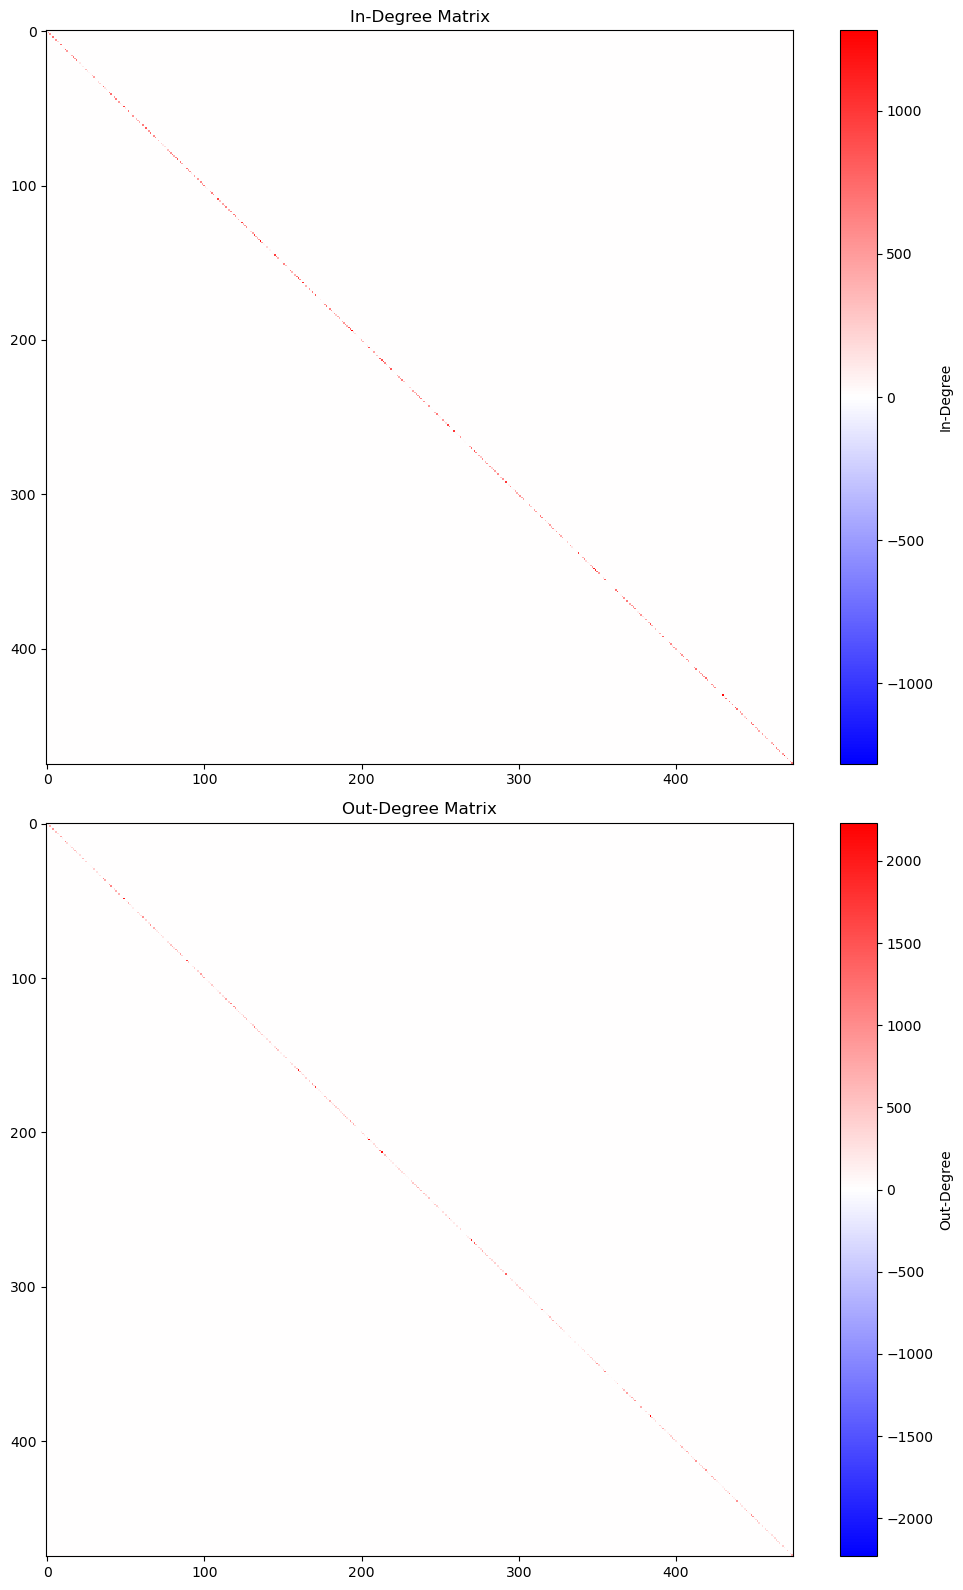

In [97]:
# Degree matrix
def compute_degree_matrix(A):
    """Compute the degree matrix of the connectivity matrix."""
    in_degrees = np.sum(A, axis=0)
    out_degrees = np.sum(A, axis=1)
    return np.diag(in_degrees), np.diag(out_degrees)

# Compute the degree matrices
D_in, D_out = compute_degree_matrix(A)

# Plot the degree matrices
plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.imshow(D_in, cmap='bwr', aspect='auto',
           vmin=-np.max(np.abs(D_in)), vmax=np.max(np.abs(D_in)),
           interpolation='none')
plt.title('In-Degree Matrix')
plt.colorbar(label='In-Degree')
plt.subplot(2, 1, 2)
plt.imshow(D_out, cmap='bwr', aspect='auto',
           vmin=-np.max(np.abs(D_out)), vmax=np.max(np.abs(D_out)),
           interpolation='none')
plt.title('Out-Degree Matrix')
plt.colorbar(label='Out-Degree')
plt.tight_layout()
plt.show()

In [98]:
# Import clustering functions
from preprocessing.clustering import connectivity_based_clustering, compare_clusterings, analyze_cluster_composition

# Perform clustering with different methods
print("=== Performing Connectivity-Based Clustering ===")

# Try different clustering methods
methods = ['spectral', 'hierarchical', 'kmeans']
clustering_results = {}

for method in methods:
    print(f"\n--- {method.capitalize()} Clustering ---")
    try:
        results = connectivity_based_clustering(
            A, 
            method=method,
            n_clusters=len(set(ctoi_list))  # Use true number as hint, but algorithm will decide
        )
        clustering_results[method] = results
        
        # Print results for each feature type
        for feature_type in ['full_connectivity', 'degree_patterns', 'connectivity_patterns']:
            if feature_type in results:
                r = results[feature_type]
                print(f"  {feature_type}: {r['n_clusters_found']} clusters, "
                      f"silhouette={r['silhouette_score']:.3f}")
                
    except Exception as e:
        print(f"  Error with {method}: {e}")
        
print(f"\nTrue number of cell types: {len(set(ctoi_list))}")

=== Performing Connectivity-Based Clustering ===

--- Spectral Clustering ---
  full_connectivity: 18 clusters, silhouette=-0.016
  degree_patterns: 18 clusters, silhouette=-0.342
  connectivity_patterns: 18 clusters, silhouette=-0.048

--- Hierarchical Clustering ---


/opt/miniconda3/envs/graphconn/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/graphconn/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/graphconn/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  full_connectivity: 18 clusters, silhouette=0.240
  degree_patterns: 18 clusters, silhouette=0.421
  connectivity_patterns: 18 clusters, silhouette=0.206

--- Kmeans Clustering ---
  full_connectivity: 18 clusters, silhouette=0.223
  degree_patterns: 18 clusters, silhouette=0.433
  connectivity_patterns: 18 clusters, silhouette=0.198

True number of cell types: 18


## Validation Against Known Cell Types

Now we compare our unsupervised clustering results with the known cell type labels to validate biological relevance.

In [106]:
best_method, best_feature

('kmeans', 'degree_patterns')

In [107]:
# Compare clustering results with ground truth
print("=== Clustering Validation Against Known Cell Types ===")

# Select best clustering result for detailed analysis
best_method = None
best_score = -1
best_feature = None

for method, results in clustering_results.items():
    for feature_type in ['full_connectivity', 'degree_patterns', 'connectivity_patterns']:
        if feature_type in results:
            score = results[feature_type]['silhouette_score']
            if not np.isnan(score) and score > best_score:
                best_score = score
                best_method = method
                best_feature = feature_type

# Added to manually select clustering method and feature type
best_method = 'spectral'
best_feature = 'full_connectivity'

if best_method:
    print(f"Best result: {best_method} with {best_feature} (silhouette={best_score:.3f})")
    
    # Get the best clustering labels
    best_labels = clustering_results[best_method][best_feature]['labels']
    
    # Compare with ground truth
    comparison = compare_clusterings(best_labels, ctoi_list)
    print(f"\nComparison with ground truth:")
    print(f"  Adjusted Rand Score: {comparison['adjusted_rand_score']:.3f}")
    print(f"  Normalized Mutual Information: {comparison['normalized_mutual_info']:.3f}")
    print(f"  Predicted clusters: {comparison['n_pred_clusters']}")
    print(f"  True clusters: {comparison['n_true_clusters']}")
    
    # Detailed cluster composition analysis
    composition = analyze_cluster_composition(best_labels, ctoi_list)
    print(f"\n=== Cluster Composition Analysis ===")
    
    for cluster_id, analysis in composition['cluster_analysis'].items():
        print(f"\nCluster {cluster_id} (n={analysis['size']}):")
        print(f"  Dominant type: {analysis['dominant_type']} (purity={analysis['purity']:.2f})")
        print(f"  Type distribution: {analysis['type_distribution']}")
        
else:
    print("No valid clustering results found.")

=== Clustering Validation Against Known Cell Types ===
Best result: spectral with full_connectivity (silhouette=0.433)

Comparison with ground truth:
  Adjusted Rand Score: 0.380
  Normalized Mutual Information: 0.686
  Predicted clusters: 18
  True clusters: 18

=== Cluster Composition Analysis ===

Cluster 0 (n=34):
  Dominant type: Delta7 (purity=0.50)
  Type distribution: {np.str_('Delta7'): np.int64(17), np.str_('EL'): np.int64(4), np.str_('EPG'): np.int64(13)}

Cluster 1 (n=28):
  Dominant type: ER4d (purity=0.86)
  Type distribution: {np.str_('ER4d'): np.int64(24), np.str_('TuBu08'): np.int64(4)}

Cluster 2 (n=29):
  Dominant type: ER2 (purity=0.41)
  Type distribution: {np.str_('ER2'): np.int64(12), np.str_('ER3w'): np.int64(6), np.str_('TuBu07'): np.int64(3), np.str_('TuBu09'): np.int64(8)}

Cluster 3 (n=42):
  Dominant type: ER2 (purity=0.69)
  Type distribution: {np.str_('ER2'): np.int64(29), np.str_('ER4d'): np.int64(1), np.str_('TuBu09'): np.int64(12)}

Cluster 4 (n=27):
 

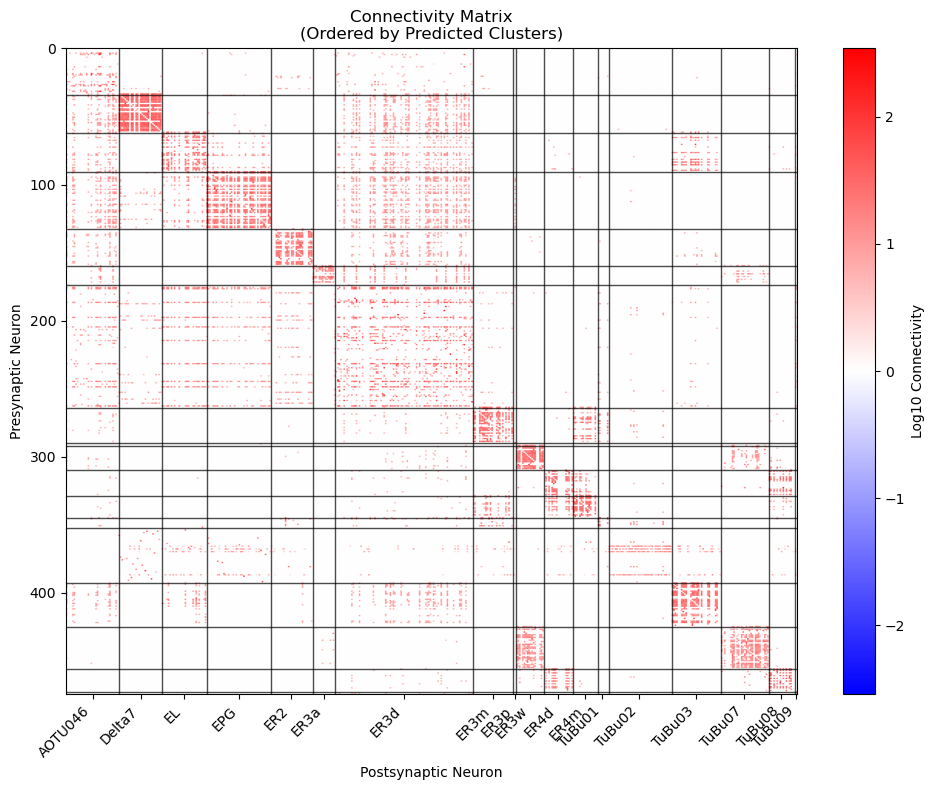

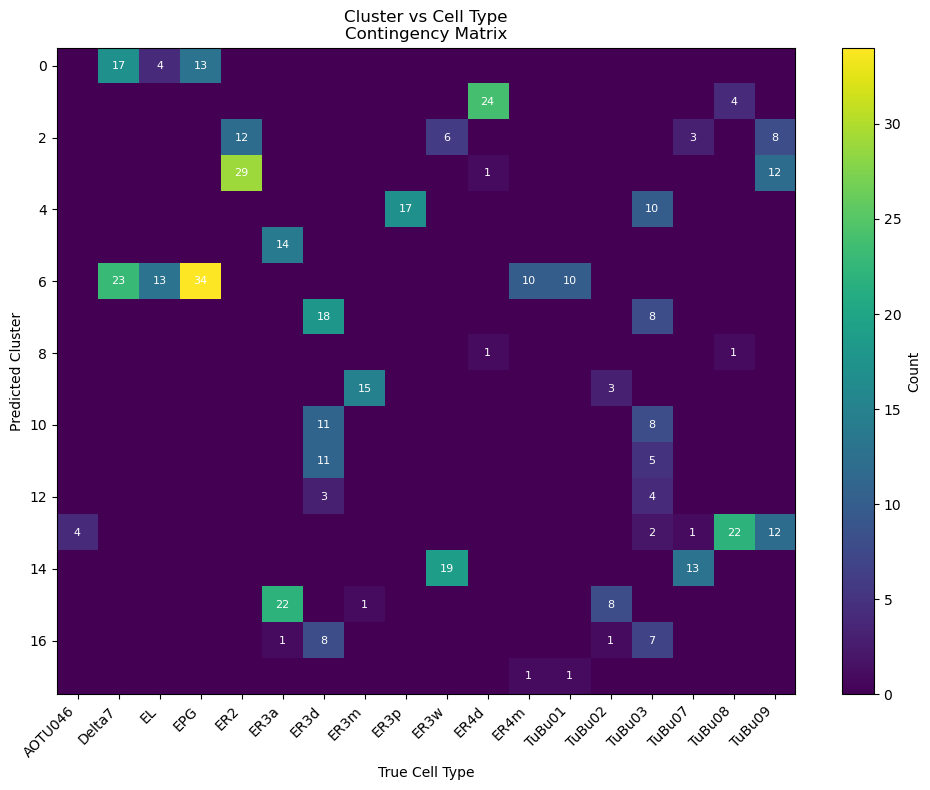

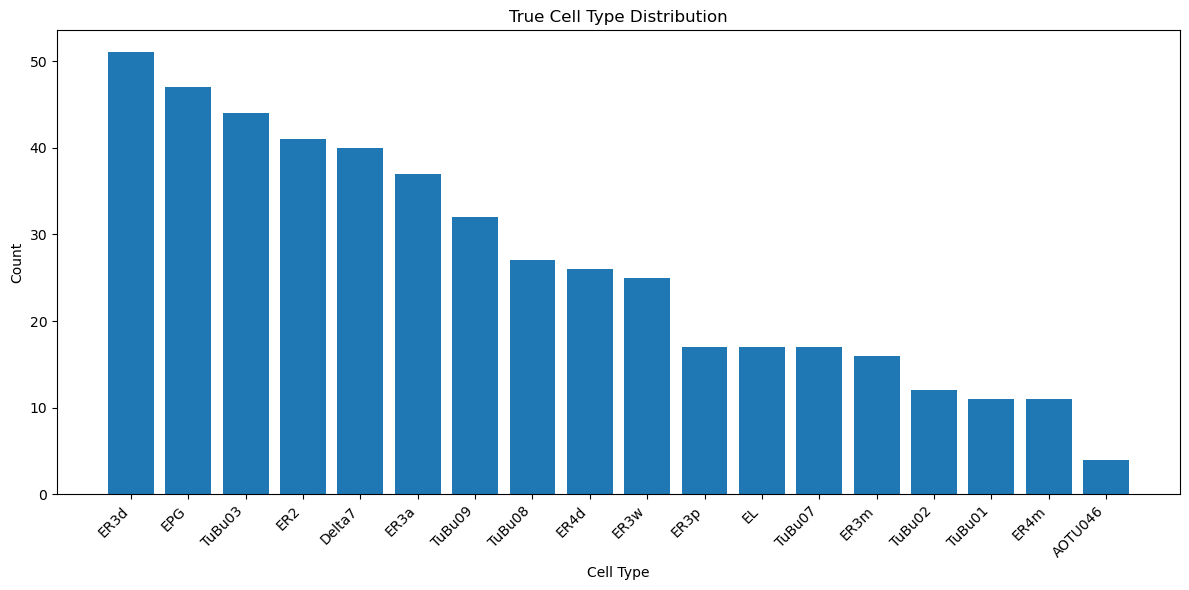


=== Summary ===
Dataset: 475 neurons from 18 cell types
Best unsupervised clustering achieved 0.380 ARI with ground truth
This suggests moderate correspondence between connectivity and cell type


In [108]:
# Visualization of clustering results
if best_method:
    # 1. Original connectivity matrix (ordered by clusters)
    cluster_order = np.argsort(best_labels)
    W_ordered = A[cluster_order][:, cluster_order]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(np.log10(np.abs(W_ordered) + 1) * np.sign(W_ordered), 
               cmap='bwr', aspect='auto',
               vmin=-np.max(np.log10(np.abs(A) + 1)), 
               vmax=np.max(np.log10(np.abs(A) + 1)))
    plt.title('Connectivity Matrix\n(Ordered by Predicted Clusters)')
    plt.xlabel('Postsynaptic Neuron')
    plt.ylabel('Presynaptic Neuron')
    
    # Add cluster boundaries
    cluster_boundaries = []
    current_cluster = best_labels[cluster_order[0]]
    for i, cluster in enumerate(best_labels[cluster_order]):
        if cluster != current_cluster:
            cluster_boundaries.append(i)
            current_cluster = cluster
    
    for boundary in cluster_boundaries:
        plt.axhline(boundary, color='k', linewidth=1, alpha=0.7)
        plt.axvline(boundary, color='k', linewidth=1, alpha=0.7)

    cluster_centers = [(cluster_boundaries[i-1] + cluster_boundaries[i]) // 2 if i > 0 else cluster_boundaries[i] // 2 for i in range(len(cluster_boundaries))]
    cluster_centers.append((cluster_boundaries[-1] + len(best_labels)) // 2)  # Add center for last cluster
    plt.xticks(cluster_centers, composition['true_type_labels'], rotation=45, ha='right')
    
    plt.colorbar(label='Log10 Connectivity')
    plt.tight_layout()
    plt.show()
    
    # 2. Cluster composition matrix
    plt.figure(figsize=(10, 8))
    contingency = composition['contingency_matrix']
    im = plt.imshow(contingency, cmap='viridis', aspect='auto')
    plt.title('Cluster vs Cell Type\nContingency Matrix')
    plt.xticks(range(len(composition['pred_cluster_labels'])), composition['true_type_labels'], rotation=45, ha='right')
    plt.xlabel('True Cell Type')
    plt.ylabel('Predicted Cluster')

    # Add text annotations
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            if contingency[i, j] > 0:
                plt.text(j, i, f'{int(contingency[i, j])}', 
                        ha='center', va='center', color='white', fontsize=8)
    
    plt.colorbar(im, label='Count')
    plt.tight_layout()
    plt.show()
    
    # 3. Cell type distribution
    plt.figure(figsize=(12, 6))
    cell_type_counts = pd.Series(ctoi_list).value_counts()
    plt.bar(range(len(cell_type_counts)), cell_type_counts.values)
    plt.title('True Cell Type Distribution')
    plt.xlabel('Cell Type')
    plt.ylabel('Count')
    plt.xticks(range(len(cell_type_counts)), cell_type_counts.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n=== Summary ===")
    print(f"Dataset: {A.shape[0]} neurons from {len(set(ctoi_list))} cell types")
    print(f"Best unsupervised clustering achieved {comparison['adjusted_rand_score']:.3f} ARI with ground truth")
    print(f"This suggests {'strong' if comparison['adjusted_rand_score'] > 0.5 else 'moderate' if comparison['adjusted_rand_score'] > 0.2 else 'weak'} correspondence between connectivity and cell type")

In [102]:
# Get the order from composition['true_type_labels']
true_type_order = composition['true_type_labels']

# Create a mapping from cell type to its order index
type_to_order = {cell_type: idx for idx, cell_type in enumerate(true_type_order)}

# Create a list of tuples (order_index, original_index) for sorting
sort_indices = []
for i, cell_type in enumerate(ctoi_list):
    order_idx = type_to_order.get(cell_type, len(true_type_order))  # Put unknowns at the end
    sort_indices.append((order_idx, i))

# Sort by order index
sort_indices.sort(key=lambda x: x[0])

# Extract the permutation indices
perm_indices = [x[1] for x in sort_indices]

# Reorder ctoi_list
ctoi_list_sorted = [ctoi_list[i] for i in perm_indices]

# Reorder noi_list
noi_list_sorted = [noi_list[i] for i in perm_indices]

# Reorder rows and columns of structural_connectivity_matrix
structural_connectivity_matrix_sorted = structural_connectivity_matrix[perm_indices][:, perm_indices]

print(f"Reordered ctoi_list according to true_type_labels order")
print(f"First 20 cell types: {ctoi_list_sorted[:20]}")
print(f"Matrix shape remains: {structural_connectivity_matrix_sorted.shape}")

Reordered ctoi_list according to true_type_labels order
First 20 cell types: ['AOTU046', 'AOTU046', 'AOTU046', 'AOTU046', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7']
Matrix shape remains: (475, 475)


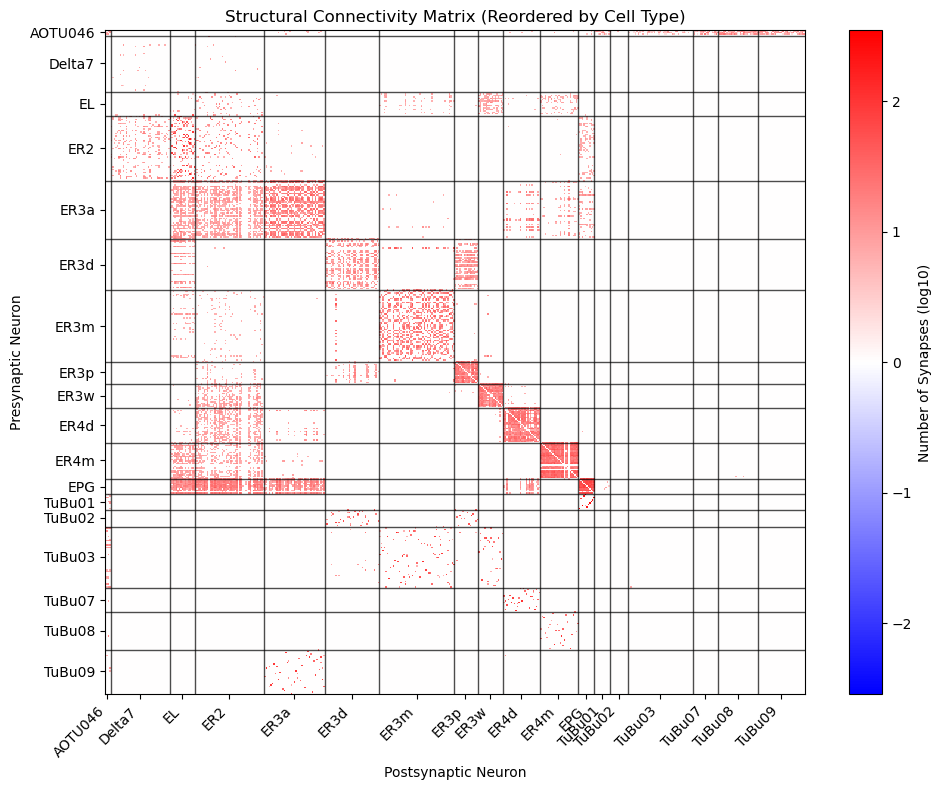

In [103]:
# Plot the connectivity matrix with neuron types
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(np.abs(structural_connectivity_matrix_sorted) + 1) * np.sign(structural_connectivity_matrix_sorted), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(structural_connectivity_matrix_sorted) + 1)), 
           vmax=np.max(np.log10(np.abs(structural_connectivity_matrix_sorted) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Structural Connectivity Matrix (Reordered by Cell Type)')
plt.xlabel('Postsynaptic Neuron')
plt.ylabel('Presynaptic Neuron')

# Add cell type boundaries
group_boundaries = []
for i in range(1, len(ctoi_list_sorted)):
    if ctoi_list_sorted[i] != ctoi_list_sorted[i - 1]:
        plt.axhline(i - 0.5, color='k', linewidth=1, alpha=0.7)
        plt.axvline(i - 0.5, color='k', linewidth=1, alpha=0.7)
        group_boundaries.append(i - 0.5)

group_centers = [(group_boundaries[i-1] + group_boundaries[i]) // 2 if i > 0 else group_boundaries[i] // 2 for i in range(len(group_boundaries))]
group_centers.append((group_boundaries[-1] + len(best_labels)) // 2)  # Add center for last cluster
plt.xticks(group_centers, ctoi, rotation=45, ha='right')
plt.yticks(group_centers, ctoi)
plt.tight_layout()
plt.show()